## Hybrid Neural-Net GARCH Models

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [171]:
import yfinance as yf
start_date = '2010-01-01'
data = yf.download(
    '^GSPC',
    start = start_date,
    interval = '1d',
    progress = False
)

### 1. NNGARCH

In [172]:
import arch
import warnings
warnings.filterwarnings('ignore')

data['ret'] = data['Adj Close'].pct_change().dropna()

garch_model = arch.arch_model(
    data['ret'].dropna(), 
    vol = 'GARCH', 
    p = 2, q = 1,
    mean = 'AR',
    lags = [1, 2]
).fit()

data['cond_vol'] = np.sqrt(garch_model.conditional_volatility)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1.991518176082924e+22
Iteration:      2,   Func. Count:     26,   Neg. LLF: 3.1770196678941507e+18
Iteration:      3,   Func. Count:     42,   Neg. LLF: 4.1179046606921915e+27
Iteration:      4,   Func. Count:     60,   Neg. LLF: 8.831101556633531e+27
Iteration:      5,   Func. Count:     78,   Neg. LLF: 4562240774500.322
Iteration:      6,   Func. Count:     92,   Neg. LLF: 3.635493963404398e+23
Iteration:      7,   Func. Count:    110,   Neg. LLF: 1.4146434437064528e+22
Iteration:      8,   Func. Count:    128,   Neg. LLF: 3.4026486037217823e+18
Iteration:      9,   Func. Count:    144,   Neg. LLF: 1.9185356501838307e+19
Iteration:     10,   Func. Count:    159,   Neg. LLF: 16632953242356.15
Iteration:     11,   Func. Count:    175,   Neg. LLF: -12104.051094490898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12104.051080208983
            Iterations: 15
            Function evaluations

In [173]:
X = pd.concat(
    [data['cond_vol'].shift(1), data['cond_vol'].shift(2)], axis = 1
).dropna()
y = data['cond_vol'].iloc[5:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'cond_vol'

In [174]:
X.head()

,t-1,t-2
Date,,
2010-01-11,0.099448,0.101846
2010-01-12,0.094715,0.099448
2010-01-13,0.090221,0.094715
2010-01-14,0.089599,0.090221
2010-01-15,0.089852,0.089599


In [175]:
y.head()

Date
2010-01-11    0.094715
2010-01-12    0.090221
2010-01-13    0.089599
2010-01-14    0.089852
2010-01-15    0.087687
Name: cond_vol, dtype: float64

In [176]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2022'], X.loc['2023':], y.loc[:'2022'], y.loc['2023':]

In [217]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 50 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.001
num_epochs = 10
batch_size = 1

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [218]:
class NNGARCH(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(NNGARCH, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()

    def forward(self, x):
        out = self.fc1(x)
        
        for layer in self.hidden_layers:
            out = layer(out)

        out = self.fc2(out)
        return out

In [219]:
model = NNGARCH(
    input_size, 
    hidden_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr = learning_rate
)

In [220]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0366
Epoch [2/10], Loss: 0.0294
Epoch [3/10], Loss: 0.0230
Epoch [4/10], Loss: 0.0175
Epoch [5/10], Loss: 0.0128
Epoch [6/10], Loss: 0.0089
Epoch [7/10], Loss: 0.0059
Epoch [8/10], Loss: 0.0036
Epoch [9/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0011


In [221]:
model.eval()
with torch.no_grad():
    predicted_volatility = model(X_test_tensor).squeeze().numpy()

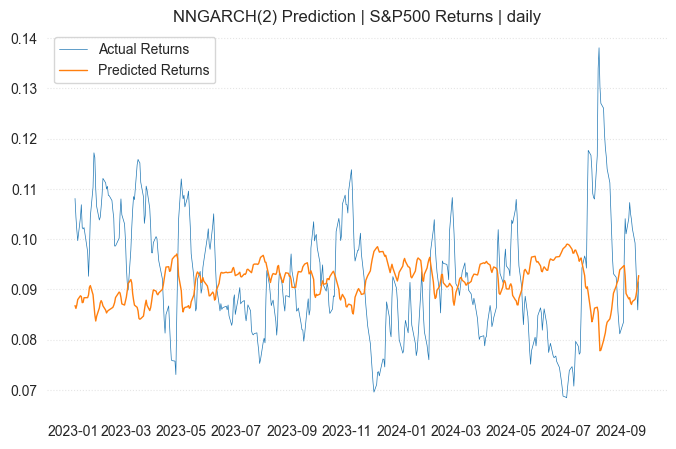

In [222]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_volatility, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'NNGARCH(2) Prediction | S&P500 Returns | daily')
plt.show()

### 2. Recurrent Neural Net & GARCH

#### 2-1. RNN-GARCH

#### 2-2. $\alpha$RNN-GARCH

#### 2-3. $\alpha_t$RNN-GARCH

### 3. Market Long Memories

#### 3-1. FIRNN-GARCH

#### 3-2. $\alpha$FIRNN-GARCH

#### 3-3. $\alpha_t$FIRNN-GARCH